In [8]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [4]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
!cd ./drive/My\ Drive/

In [5]:
!pip install -r requirements.txt

  Using cached https://files.pythonhosted.org/packages/e5/fe/db8159d4d79109c6c8942abe77c7ba6b6e008c32ae55870a35e73fa10db3/stable_baselines-2.10.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/91/2d/2ed263449a078cd9c8a9ba50ebd50123adf1f8cfbea1492f9084169b89d9/tensorboard-1.14.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/3c/d5/21860a5b11caf0678fbc8319341b0ae21a07156911132e0e71bffed0510d/tensorflow_estimator-1.14.0-py2.py3-none-any.whl
     |████████████████████████████████| 411.0MB 41kB/s 
ERROR: tensorflow 1.15.2 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow 1.15.2 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 1.14.0 which is incompatible.
ERROR: tensorflow 1.15.2 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 1.14.0 which is incompatible.
ERROR: tensorflow-gpu 1.15.2 has requirement gast==0.2.2, but you'll have gast 0.3

In [0]:
import os
import pickle
import pandas as pd
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from rlenv.StockTradingEnv import StockTradingEnv

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font = fm.FontProperties(fname='font/wqy-microhei.ttc')
# plt.rc('font', family='Source Han Sans CN')
plt.rcParams['axes.unicode_minus'] = False


def stock_trade(stock_file):
    day_profits = []
    action_log=[]
    df = pd.read_csv(stock_file)
    df = df.sort_values('date')

    # The algorithms require a vectorized environment to run
    env = DummyVecEnv([lambda: StockTradingEnv(df)])

    model = PPO2(MlpPolicy, env, verbose=0, tensorboard_log='./log')
    model.learn(total_timesteps=int(6*1e4))

    df_test = pd.read_csv(stock_file.replace('train', 'test'))

    env = DummyVecEnv([lambda: StockTradingEnv(df_test)])
    obs = env.reset()
    for i in range(len(df_test) - 1):
        action, _states = model.predict(obs)
        action_log.append(action[0][0])
        print(action)
        obs, rewards, done, info = env.step(action)
        profit = env.render()
        day_profits.append(profit)
        if done:
            break
    return day_profits,action_log


def find_file(path, name):
    # print(path, name)
    for root, dirs, files in os.walk(path):
        for fname in files:
            if name in fname:
                return os.path.join(root, fname)


def test_a_stock_trade(stock_code):
    stock_file = find_file('./drive/My Drive/RL-Stock/stockdata/train', str(stock_code))

    daily_profits,action_log = stock_trade(stock_file)
    return daily_profits,action_log,stock_code

def plot_results(daily_profits,action_log,stock_code):
    fig, ax = plt.subplots()
    ax.plot(daily_profits, '-o', label=stock_code, marker='o', ms=10, alpha=0.7, mfc='orange')
    ax.plot(action_log, '-r', label=stock_code, marker='o', ms=10, alpha=0.7, mfc='orange')
    ax.grid()
    plt.xlabel('step')
    plt.ylabel('profit')
    ax.legend(prop=font)
    fig1, ax1 = plt.subplots()
    ax1.plot(action_log, '-r', label=stock_code, marker='o', ms=10, alpha=0.7, mfc='orange')
    ax1.grid()
    plt.xlabel('step')
    plt.ylabel('profit')
    ax1.legend(prop=font)
    # plt.show()
    plt.savefig(f'./img/{stock_code}.png')


def multi_stock_trade():
    start_code = 600000
    max_num = 3000

    group_result = []

    for code in range(start_code, start_code + max_num):
        stock_file = find_file('./drive/My Drive/RL-Stock/stockdata/train', str(code))
        if stock_file:
            try:
                profits = stock_trade(stock_file)
                group_result.append(profits)
            except Exception as err:
                print(err)

    with open(f'code-{start_code}-{start_code + max_num}.pkl', 'wb') as f:
        pickle.dump(group_result, f)




In [57]:
if __name__ == '__main__':
    # multi_stock_trade()
    daily_profits,action_log,stock_code=test_a_stock_trade('sz.000333')
    
    # ret = find_file('./stockdata/train', '600036')
    # print(ret)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/content/rlenv/StockTradingEnv.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


[[0.3324512 1.       ]]
------------------------------
Step: 1
Balance: -84.19521270558471
Shares held: 5489 (Total sold: 0)
Avg cost for held shares: 54.67010297189025 (Total sales value: 0)
Net worth: 299900.0 (Max net worth: 300000)
Profit: -100.0
[[0.88005555 0.        ]]
------------------------------
Step: 2
Balance: -184.1952127055847
Shares held: 5489 (Total sold: 0)
Avg cost for held shares: 54.68832122658145 (Total sales value: 0)
Net worth: 299849.3169197616 (Max net worth: 300000)
Profit: -150.68308023840655
[[0. 0.]]
------------------------------
Step: 3
Balance: -284.1952127055847
Shares held: 5489 (Total sold: 0)
Avg cost for held shares: 54.70653948127265 (Total sales value: 0)
Net worth: 302125.9351909604 (Max net worth: 302125.9351909604)
Profit: 2125.9351909604156
[[0. 0.]]
------------------------------
Step: 4
Balance: -384.1952127055847
Shares held: 5489 (Total sold: 0)
Avg cost for held shares: 54.724757735963856 (Total sales value: 0)
Net worth: 304843.41463227

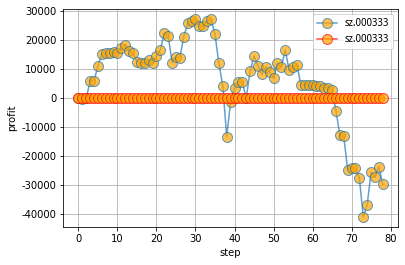

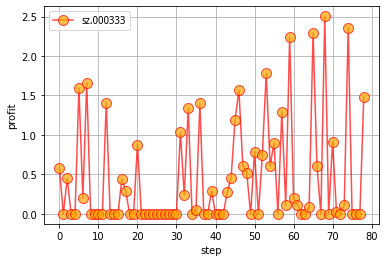

In [54]:
plot_results(daily_profits,action_log,stock_code)